In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Loading data

In [2]:
buildings = pd.read_csv("../data/buildings.csv")

In [3]:
events = pd.read_csv("../data/events.csv")

In [4]:
buildings.head(2)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0
1,26200 mich ave inkster mi 48141,0,[116216],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1


In [5]:
events.head(2)

,event_id,lon,lat,addr,type
0,0,-83.161039,42.383998,13120-13130 ilene st,1
1,1,-83.080919,42.440471,1485 e outer dr,1


In [6]:
events['type'].value_counts()   # types: 1: 311-calls, 2: crimes, 3: blight violations

3    307804
2    119394
1     19679
4      6315
Name: type, dtype: int64

Add counts for each type into buildings

In [7]:
def str_to_list(events_str):
    events_list = events_str.rstrip(']').lstrip('[').split(', ')
    return events_list

In [8]:
buildings.loc[:, 'event_id_list'] = buildings.loc[:,'event_id_list'].copy().apply(lambda x: str_to_list(x))

In [9]:
buildings['311-calls'] = np.zeros(buildings.shape[0])
buildings['crimes'] = np.zeros(buildings.shape[0])
buildings['blight_violations'] = np.zeros(buildings.shape[0])
buildings['permit_cnt'] = np.zeros(buildings.shape[0])

for i in range(buildings.shape[0]):
    for event in buildings.loc[i, 'event_id_list']:
        event = int(event)
        event_type = events.loc[event,'type']
        if event_type == 1:
              buildings.loc[i, '311-calls'] += 1
        elif event_type == 2:
              buildings.loc[i, 'crimes'] += 1
        elif event_type == 3:
              buildings.loc[i, 'blight_violations'] += 1
        elif event_type == 4:
              buildings.loc[i, 'permit_cnt'] += 1
        else:
              print("unexpected event_type: %d in row %d" % (event_type, i))

In [10]:
buildings[['311-calls','crimes','blight_violations','permit_cnt']].describe()

,311-calls,crimes,blight_violations,permit_cnt
count,130727.000000,130727.000000,130727.000000,130727.000000
mean,0.134142,0.831328,0.760715,0.021373
std,0.390493,1.094696,0.958943,0.155434
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,12.000000,9.000000,12.000000,5.000000


### Normalize longitude and latitude

In [11]:
buildings['norm_lon'] = (buildings['lon'].copy() - np.mean(buildings['lon'].values))/np.std(buildings['lon'].values)
buildings['norm_lat'] = (buildings['lat'].copy() - np.mean(buildings['lat'].values))/np.std(buildings['lat'].values)

In [12]:
buildings.head(2)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687
1,26200 mich ave inkster mi 48141,0,[116216],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1,0.0,1.0,0.0,0.0,-1.898702,-2.553627


In [13]:
buildings.to_csv('../data/buildings_with_features.csv', index=False)

### Analysis features

In [14]:
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split

In [321]:
buildings = pd.read_csv('../data/buildings_with_features.csv')
balanced_data = pd.read_csv('../data/balanced_data.csv')
balanced_keys = pd.read_csv('../data/balanced_keys.csv')

In [322]:
buildings.head(2)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat
0,13500 norborne,0,['138721'],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687
1,26200 mich ave inkster mi 48141,0,['116216'],42.2954,-83.2968,-83.297006,42.295298,-83.296594,42.295502,1,0.0,1.0,0.0,0.0,-1.898702,-2.553627


In [323]:
balanced_data.head(3)

,addr,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id
0,15360 tracey,"[448971, 118987]",42.403010,-83.180173,-83.180379,42.402908,-83.179968,42.403112,38754
1,4817 chopin,[143959],42.332660,-83.134467,-83.134672,42.332558,-83.134261,42.332762,60569
2,5300 wayburn st,[13405],42.400448,-82.955224,-82.955430,42.400346,-82.955019,42.400550,121589


In [324]:
balanced_buildings = buildings.loc[buildings['building_id'].isin(balanced_data['building_id'].values)].copy()

In [325]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'crimes', 'blight_violations']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt'] 

In [326]:
labels = balanced_buildings['blighted']
data = balanced_buildings.drop(names_to_drop, axis=1, inplace=False)

In [327]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)

In [328]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [329]:
dtrain = xgb.DMatrix(x, label=y)
deval = xgb.DMatrix(x_eval, label=y_eval)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'booster': 'gbtree',
    'subsample': 1.0,
    'max_depth': 5,
    'min_child_weight': 2,
    'eta': 0.2,
    'gamma': 3,
    'objective':'binary:logistic',
    'eval_metric': 'auc',
    'lambda': 3, # L2 regularization,
    'alpha': 1  # L1 regularization
}
watchlist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 1000

In [330]:
evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result, early_stopping_rounds=20, verbose_eval=False)

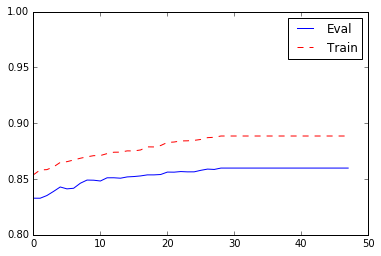

In [331]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,1.0)
plt.show()

In [332]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [333]:
round(roc_auc_score(y_test, preds_proba), 5)

0.86687000000000003

In [334]:
dtrain_total = xgb.DMatrix(x_train, label=y_train)

+  Cross Validation

In [335]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=99,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.851934	test-auc:0.838149
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.852181	test-auc:0.838536
[2]	train-auc:0.854876	test-auc:0.840773
[3]	train-auc:0.857873	test-auc:0.842309
[4]	train-auc:0.862297	test-auc:0.846874
[5]	train-auc:0.86441	test-auc:0.848298
[6]	train-auc:0.865076	test-auc:0.849315
[7]	train-auc:0.866884	test-auc:0.849802
[8]	train-auc:0.867735	test-auc:0.849666
[9]	train-auc:0.869543	test-auc:0.849594


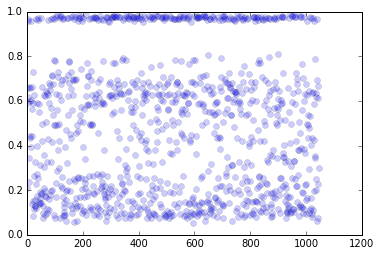

In [336]:
plt.plot(np.arange(len(preds_proba)), preds_proba, 'bo', alpha=0.2)
plt.show()

In [337]:
y_pred_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

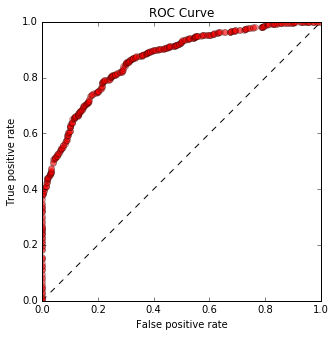

In [338]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

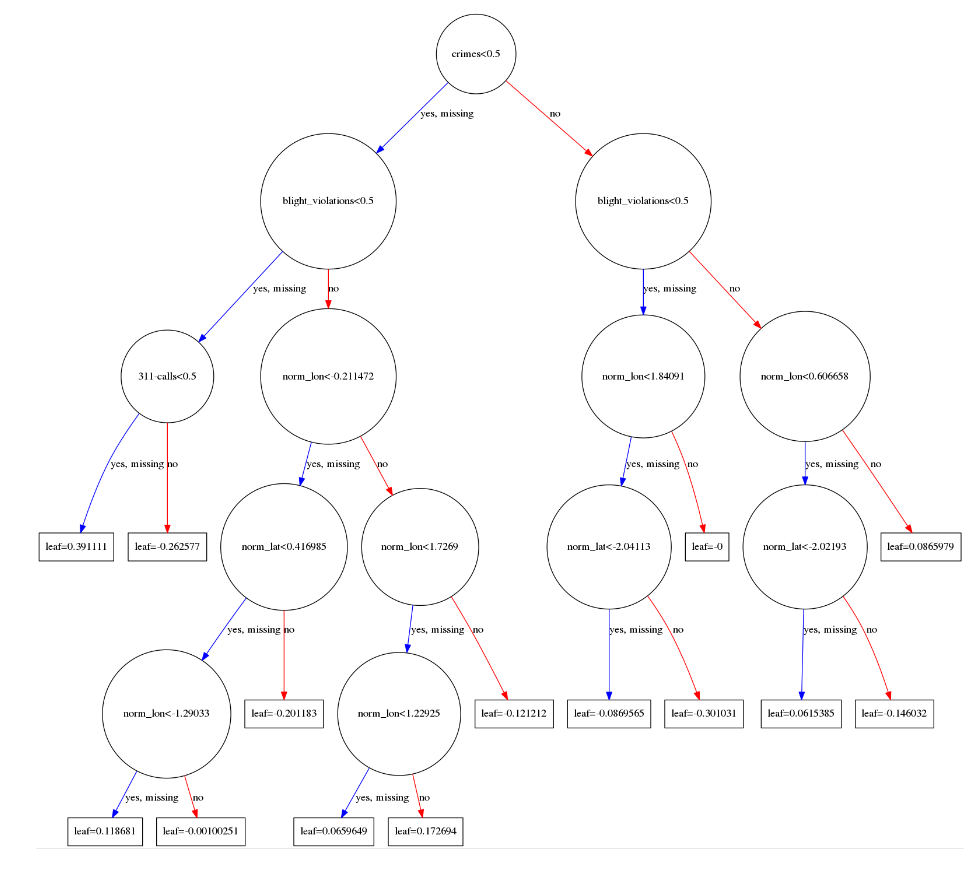

In [342]:
fig, ax = plt.subplots(figsize=(20,15), dpi=600)
xgb.plot_tree(bst, num_trees=0, ax=ax)
plt.show()

In [42]:
feat_imp = [(k,v) for (k,v) in bst.get_fscore().items()]   # python3
feat_imp.sort()

In [43]:
feat_names, feat_imps = zip(*feat_imp)

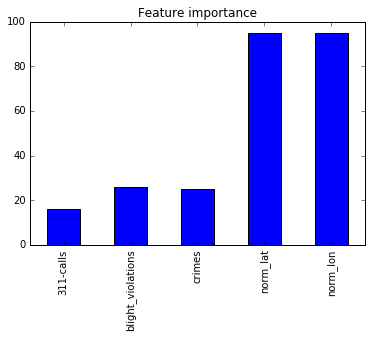

In [44]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)

fig = plt.figure()
feat_imp_vis.plot(kind='bar', title='Feature importance')

According to this simplified analysis, **location** has the most predictive power for blightness. ('norm_lat' and 'norm_lon' correspond to 'normalized latitude' and 'normalized longitude' respectively)

## More features from differentiating crimes

In [45]:
data_crimes = pd.read_csv('../data/data_crime.csv')

/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
data_crimes.CATEGORY.unique()

array(['ASSAULT', 'LARCENY', 'STOLEN VEHICLE', 'WEAPONS OFFENSES',
       'TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS', 'BURGLARY',
       'AGGRAVATED ASSAULT', 'DAMAGE TO PROPERTY',
       'TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED', 'ROBBERY', 'FRAUD',
       'OBSTRUCTING JUDICIARY', 'DANGEROUS DRUGS', 'HOMICIDE',
       'SOLICITATION', 'OUIL DISPOSE OF VEHICLE TO AVOID FORFEITURE',
       'FAMILY OFFENSE', 'ARSON', 'ESCAPE', 'OBSTRUCTING THE POLICE',
       'RUNAWAY', 'BRIBERY', 'KIDNAPING', 'EXTORTION', 'OTHER BURGLARY',
       'STOLEN PROPERTY', 'HEALTH-SAFETY', 'VAGRANCY (OTHER)',
       'ENVIRONMENT', 'EMBEZZLEMENT', 'FORGERY', 'CONSPIRACY BY COMPUTER',
       'ANTITRUST', 'PUBLIC PEACE', 'LIQUOR', 'OUIL', 'OBSCENITY',
       'SOVEREIGNTY', 'TAX REVENUE', 'NEGLIGENT HOMICIDE', 'GAMBLING',
       'IMMIGRATION', 'CONGRESS', 'JUSTIFIABLE HOMICIDE', 'REVOKED',
       'ELECTION LAWS', 'DRUNKENNESS', 'FELONY DEATH FROM FLEEING VEHICLE',
       'MISCELLANEOUS ARREST', 'MILITARY'], dtype=ob

In [47]:
crime_categories = {'more_serious': ['ASSAULT', 'LARCENY', 'STOLEN VEHICLE', 'BURGLARY', 'AGGRAVATED ASSAULT',\
                    'ROBBERY', 'KIDNAPING', 'OTHER BURGLARY', 'NEGLIGENT HOMICIDE', 'JUSTIFIABLE HOMICIDE',\
                    'FELONY DEATH FROM FLEEING VEHICLE', 'DANGEROUS DRUGS', 'ARSON', 'HOMICIDE'], \
                   'less_serious': ['WEAPONS OFFENSES', 'TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS', \
                    'DAMAGE TO PROPERTY', 'TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED', 'FRAUD', 'OBSTRUCTING THE POLICE',\
                   'RUNAWAY', 'BRIBERY', 'EXTORTION', 'STOLEN PROPERTY', 'HEALTH-SAFETY', 'VAGRANCY (OTHER)', \
                    'ENVIRONMENT', 'EMBEZZLEMENT', 'FORGERY', 'CONSPIRACY BY COMPUTER', 'ANTITRUST', 'PUBLIC PEACE',\
                   'LIQUOR', 'OUIL', 'OBSCENITY', 'SOVEREIGNTY', 'TAX REVENUE', 'GAMBLING', 'IMMIGRATION', 'CONGRESS',\
                   'REVOKED', 'ELECTION LAWS', 'DRUNKENNESS', 'MISCELLANEOUS ARREST', 'MILITARY', 'SOLICITATION', \
                   'OUIL DISPOSE OF VEHICLE TO AVOID FORFEITURE', 'FAMILY OFFENSE', 'ESCAPE', 'OBSTRUCTING JUDICIARY']}

# based on data from gis.chicagopolice.org

In [48]:
data_crimes.head(2)

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,LON,LAT,LOCATION,addr,event_id,type
0,53256,1953933,1506030028.1,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001.0,06/03/2015 12:00:00 AM,2,1007.0,10.0,City Council District 5,PETOSKEY-OTSEGO,5334.0,-83.1221,42.3678,"PETOSKEY\n09100\n(42.3676, -83.1219)",09100 petoskey,19679,2
1,17631,1917717,1503010158.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,03/01/2015 12:00:00 AM,9,608.0,6.0,City Council District 7,GRANDALE,5452.0,-83.2035,42.3724,"00 PLYMOUTH AND MANSFIELD\n(42.3725, -83.2033)",00 plymouth and mansfield,19680,2


In [49]:
def cat_crime(crime_str):
    '''numerical category: 
       ---- more_serious: 1
       ---- less_serious: 0
       ---- unclassified: -1
    '''
    if crime_str in crime_categories['more_serious']:
        return 1
    elif crime_str in crime_categories['less_serious']:
        return 0
    else:
        return -1

In [50]:
data_crimes['num_cat'] = data_crimes['CATEGORY'].apply(cat_crime)

In [51]:
data_crimes['num_cat'].unique()   # all crimes classified, no -1 encountered

array([1, 0])

In [52]:
buildings.head(1)  # refresher

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat
0,13500 norborne,0,['138721'],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687


In [53]:
less_serious_crime_event_ids = data_crimes.loc[data_crimes['num_cat']==0,'event_id'].values

In [54]:
more_serious_crime_event_ids = data_crimes.loc[data_crimes['num_cat']==1,'event_id'].values

In [55]:
buildings.loc[:, 'event_id_list'] = buildings.loc[:,'event_id_list'].copy().apply(lambda x: str_to_list(x))

In [56]:
buildings['less_serious_crimes'] = 0       # count of less serious crimes
buildings['more_serious_crimes'] = 0       # count of more serious crimes
buildings['event_id_list'] = buildings['event_id_list'].apply(lambda x: [int(i.rstrip("'").lstrip("'")) for i in x])

for i in range(buildings.shape[0]):
    for event in buildings.loc[i, 'event_id_list']:
        if event in less_serious_crime_event_ids:
            buildings.loc[i, 'less_serious_crimes'] += 1
        elif event in more_serious_crime_event_ids:
            buildings.loc[i, 'more_serious_crimes'] += 1

In [57]:
buildings.head(1)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat,less_serious_crimes,more_serious_crimes
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687,1,0


In [58]:
buildings.to_csv('../data/buildings_with_features_2.csv', index=False)

In [59]:
balanced_buildings = buildings.loc[buildings['building_id'].isin(balanced_data['building_id'].values)].copy()

In [60]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'blight_violations', 'less_serious_crimes', 'more_serious_crimes']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt', 'crimes'] 

In [61]:
labels = balanced_buildings['blighted']
data = balanced_buildings.drop(names_to_drop, axis=1, inplace=False)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)

In [63]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [207]:
dtrain = xgb.DMatrix(x, label=y)
deval = xgb.DMatrix(x_eval, label=y_eval)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
    'booster': 'gbtree',
    'subsample': 1.0,
    'max_depth': 8,
    'min_child_weight': 8,
    'eta': 0.1,
    'gamma': 5,
    'objective':'binary:logistic',
    'eval_metric': 'auc',
    'lambda': 2, # L2 regularization,
    'alpha': 0  # L1 regularization
}
watchlist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 2000

In [208]:
evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result, early_stopping_rounds=20, verbose_eval=False)

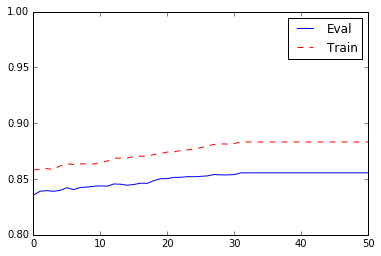

In [209]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,1.0)
plt.show()

In [210]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [211]:
round(roc_auc_score(y_test, preds_proba), 5)

0.86460000000000004

In [212]:
dtrain_total = xgb.DMatrix(x_train, label=y_train)

+  Cross Validation

In [213]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=99,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.856021	test-auc:0.839913
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.857758	test-auc:0.84213
[2]	train-auc:0.858127	test-auc:0.842366
[3]	train-auc:0.859393	test-auc:0.842376
[4]	train-auc:0.859571	test-auc:0.842448
[5]	train-auc:0.860936	test-auc:0.84314
[6]	train-auc:0.861729	test-auc:0.843287
[7]	train-auc:0.862135	test-auc:0.842917
[8]	train-auc:0.863142	test-auc:0.844508
[9]	train-auc:0.864206	test-auc:0.844289


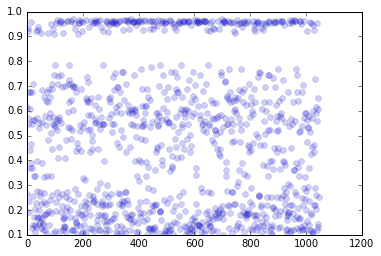

In [214]:
plt.plot(np.arange(len(preds_proba)), preds_proba, 'bo', alpha=0.2)
plt.show()

In [215]:
y_pred_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

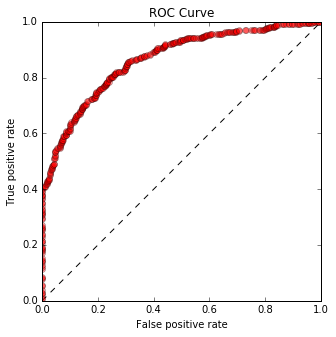

In [216]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [217]:
feat_imp = [(k,v) for (k,v) in bst.get_fscore().items()]   # python3
feat_imp.sort()

In [218]:
feat_names, feat_imps = zip(*feat_imp)

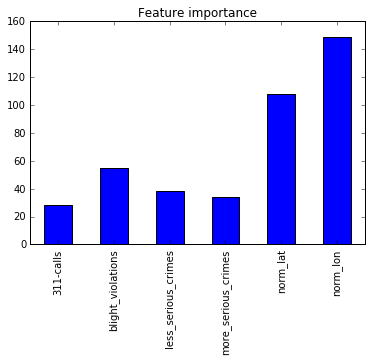

In [219]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)

fig = plt.figure()
feat_imp_vis.plot(kind='bar', title='Feature importance')

The additional feature created using differentiated crimes did not provide a better answer.

## SVM

In [220]:
# Train using another balanced data set (1:1 blighted vs nonblighted) with nonblighted of another list of random indexes
balanced_data_2 = pd.read_csv('../data/balanced_data_2.csv')
balanced_keys_2 = pd.read_csv('../data/balanced_keys_2.csv')

In [221]:
balanced_buildings_2 = buildings.loc[buildings['building_id'].isin(balanced_data_2['building_id'].values)].copy()

In [222]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'blight_violations', 'less_serious_crimes', 'more_serious_crimes']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt', 'crimes'] 

In [223]:
labels_2 = balanced_buildings_2['blighted']
data_2 = balanced_buildings_2.drop(names_to_drop, axis=1, inplace=False)

In [224]:
x_train, x_test, y_train, y_test = train_test_split(data_2, labels_2, test_size=0.2, stratify=labels, random_state=0)

In [225]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=500)

In [226]:
from sklearn.svm import SVC

In [232]:
clf = SVC(C=0.8, kernel='rbf', probability=True)

In [233]:
clf.fit(x_train, y_train)

SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [234]:
y_pred_2 = clf.predict_proba(x_test)

In [235]:
round(roc_auc_score(y_test, y_pred_2[:,1]), 5)

0.83265

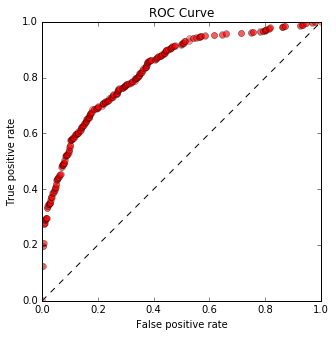

In [236]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2[:,1], pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

## More features from differentiating 'blight violations'

We still have only a very small number of features so far. And one should still benefit from exploring features.

In [343]:
data_violations = pd.read_csv('../data/data_bv.csv')

/usr/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [344]:
data_violations.columns

Index(['TicketID', 'TicketNumber', 'AgencyName', 'ViolName',
       'ViolationStreetNumber', 'ViolationStreetName', 'MailingStreetNumber',
       'MailingStreetName', 'MailingCity', 'MailingState', 'MailingZipCode',
       'NonUsAddressCode', 'Country', 'TicketIssuedDT', 'TicketIssuedTime',
       'HearingDT', 'CourtTime', 'ViolationCode', 'ViolDescription',
       'Disposition', 'FineAmt', 'AdminFee', 'LateFee', 'StateFee',
       'CleanUpCost', 'JudgmentAmt', 'PaymentStatus', 'Void',
       'ViolationCategory', 'ViolationAddress', 'MailingAddress', 'coord',
       'addr', 'lon', 'lat', 'event_id', 'type'],
      dtype='object')

In [345]:
data_violations.FineAmt.unique()     # this indicate importance of violations

array(['$1500.00', '$100.00', '$3500.00', '$200.00', '$2500.00', '$500.00',
       '$10000.00', '$1000.00', '$5000.00', '$250.00', '$25.00', '$300.00',
       '$50.00', '$750.00', '$20.00', '$125.00', '$1470.00', '$350.00',
       '$600.00', '$3000.00', '$1250.00', '$400.00', '$170.00', '$1750.00',
       '$1200.00', '$2000.00', '$970.00', '$7000.00', nan, '$150.00',
       '$2695.00', '$8000.00', '$95.00', '$345.00', '$270.00', '$30.00',
       '$450.00', '$160.00', '$220.00', '$375.00', '$1030.00', '$1.00',
       '$677.00', '$280.00', '$4000.00', '$90.00', '$290.00', '$370.00',
       '$1450.00', '$800.00', '$0.00', '$60.00', '$440.00', '$470.00',
       '$230.00'], dtype=object)

In [346]:
len(data_violations.ViolationCode.value_counts())   # Too many kind of violations if by category

265

In [347]:
buildings = pd.read_csv('../data/buildings_with_features_2.csv')
balanced_data = pd.read_csv('../data/balanced_data.csv')
balanced_keys = pd.read_csv('../data/balanced_keys.csv')

In [348]:
def get_num_amt(FineAmt):
    '''convert FineAmt string to numerical values'''
    amt_str = FineAmt.tolist()[0]
    if isinstance(amt_str, float):   # nan
        # print(amt_str)
        return 0
    amt_str = amt_str.lstrip('$')
    amt = float(amt_str)
    return amt 

In [349]:
buildings.loc[:, 'event_id_list'] = buildings.loc[:,'event_id_list'].copy().apply(lambda x: str_to_list(x))

In [350]:
buildings.head(1)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,311-calls,crimes,blight_violations,permit_cnt,norm_lon,norm_lat,less_serious_crimes,more_serious_crimes
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,0.0,1.0,0.0,0.0,-1.905905,-0.172687,1,0


In [351]:
buildings['trivial_v'] = 0       # count of violation of minimal importance (< $100)
buildings['small_v'] = 0       # count of violation of small importance ($100 <= v < $1000 )
buildings['medium_v'] = 0      # count of violation with ($1000 <= v < $5000)
buildings['heavy_v'] = 0       # count of violation with (>=$5000)

buildings['event_id_list'] = buildings['event_id_list'].apply(lambda x: [int(i.rstrip("'").lstrip("'")) for i in x])

In [352]:
violation_events = data_violations['event_id'].values
for i in range(buildings.shape[0]):
    for event in buildings.loc[i, 'event_id_list']:
        if event in violation_events:
            amt = get_num_amt(data_violations.loc[data_violations['event_id']==event, 'FineAmt'])
            if amt < 100:
                buildings.loc[i, 'trivial_v'] += 1
            elif amt >= 100 and amt < 1000:
                buildings.loc[i, 'small_v'] += 1
            elif amt >= 1000 and amt < 5000:
                buildings.loc[i, 'medium_v'] += 1
            elif amt >= 5000:
                buildings.loc[i, 'heavy_v'] += 1
            else: # nan
                buildings.loc[i, 'trivial_v'] += 1

In [353]:
buildings.head(1)

,addr,blighted,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,building_id,...,blight_violations,permit_cnt,norm_lon,norm_lat,less_serious_crimes,more_serious_crimes,trivial_v,small_v,medium_v,heavy_v
0,13500 norborne,0,[138721],42.3842,-83.2975,-83.297706,42.384098,-83.297294,42.384302,0,...,0.0,0.0,-1.905905,-0.172687,1,0,0,0,0,0


In [1029]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'less_serious_crimes', 'more_serious_crimes', 'trivial_v', 'small_v', 'medium_v', 'heavy_v']
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'permit_cnt', 'crimes', 'blight_violations'] 

In [1030]:
buildings.to_csv('../data/buildings_with_features_3.csv', index=False)

In [1031]:
balanced_buildings = buildings.loc[buildings['building_id'].isin(balanced_data['building_id'].values)].copy()

In [1032]:
labels = balanced_buildings['blighted']
data = balanced_buildings.drop(names_to_drop, axis=1, inplace=False)

In [1033]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=1234)

In [1038]:
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=6890)

In [1039]:
dtrain = xgb.DMatrix(x, label=y)
deval = xgb.DMatrix(x_eval, label=y_eval)
dtest = xgb.DMatrix(x_test, label=y_test)
param = {
        'booster': 'gbtree',
        'subsample': 1.0,
        'max_depth': 7,
        'min_child_weight': 4.0,
        'eta': 0.2,
        'gamma': 3,
        'objective':'binary:logistic',
        'eval_metric': 'auc',
        'lambda': 3, # L2 regularization,
        'alpha': 0.5  # L1 regularization
    }
watchlist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 1000

In [1040]:
evals_result = {}
bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result, early_stopping_rounds=40, verbose_eval=False)

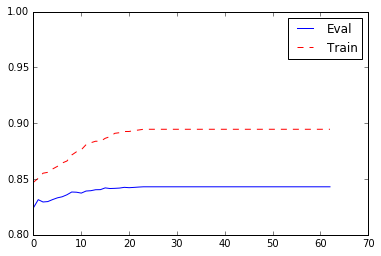

In [1041]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,1.0)
plt.show()

In [1042]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [1043]:
round(roc_auc_score(y_test, preds_proba), 5)

0.86672000000000005

In [1044]:
dtrain_total = xgb.DMatrix(x_train, label=y_train)

+  Cross Validation

In [1045]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=99,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.84792	test-auc:0.824964
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.849289	test-auc:0.826005
[2]	train-auc:0.852226	test-auc:0.82769
[3]	train-auc:0.854858	test-auc:0.829408
[4]	train-auc:0.85832	test-auc:0.832602
[5]	train-auc:0.860584	test-auc:0.833464
[6]	train-auc:0.862362	test-auc:0.835505
[7]	train-auc:0.865221	test-auc:0.83639
[8]	train-auc:0.868371	test-auc:0.839194
[9]	train-auc:0.87067	test-auc:0.840195


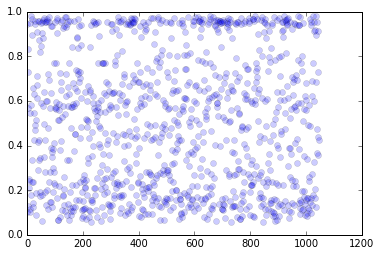

In [972]:
plt.plot(np.arange(len(preds_proba)), preds_proba, 'bo', alpha=0.2)
plt.show()

In [973]:
y_pred_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

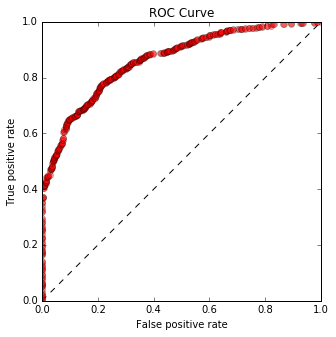

In [974]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [975]:
feat_imp = [(k,v) for (k,v) in bst.get_fscore().items()]   # python3
feat_imp.sort()

In [976]:
feat_names, feat_imps = zip(*feat_imp)

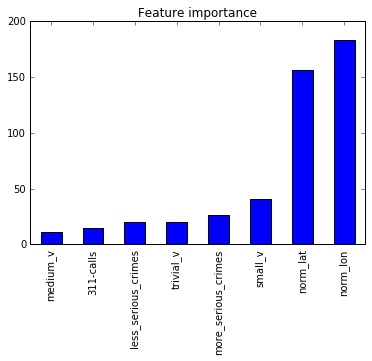

In [977]:
feat_imp_vis = pd.Series(feat_imps, index=feat_names)
feat_imp_vis.sort_values(inplace=True)
fig = plt.figure()
feat_imp_vis.plot(kind='bar', title='Feature importance')

# Bagging

More features produced by differentiating kinds of crimes or kinds of violations did not improve our power of predictions.
We can use bagging to take advantage of extra samples not utilized for nonblighted buildings.

## Extra data

In [1309]:
blighted_buildings = buildings.loc[buildings['blighted'] == 1, :].copy()
nonblighted_buildings = buildings.loc[buildings['blighted']==0, :].copy()

In [1310]:
n_blighted = blighted_buildings.shape[0]
n_nonblighted = nonblighted_buildings.shape[0]
print("number of blighted buildings: %d" % n_blighted)
print("number of non-blighted buildings: %d " % n_nonblighted)

number of blighted buildings: 2615
number of non-blighted buildings: 128112 


+  Hold test data

In [1371]:
feature_names = ['norm_lat', 'norm_lon', '311-calls', 'crimes', 'blight_violations', ]
feature_types = ['float', 'float', 'int', 'int', 'int', 'int']
names_to_drop = ['building_id','blighted','addr','event_id_list','lat','lon','llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat', 'less_serious_crimes', 'more_serious_crimes', 'trivial_v', 'small_v', 'medium_v', 'heavy_v', 'permit_cnt'] 

In [1372]:
n_test_b = int(n_blighted*0.2)  # number for blighted buildings in test

In [1373]:
index_b_test = np.random.choice(blighted_buildings.index, n_test_b, replace=False) #blighted
index_nb_test = np.random.choice(nonblighted_buildings.index, n_test_b, replace=False) #nonblighted

In [1374]:
blighted_test = blighted_buildings.loc[index_b_test,:]
nonblighted_test = nonblighted_buildings.loc[index_nb_test,:]
balanced_test = pd.concat([blighted_test.copy(), nonblighted_test.copy()])
balanced_test = balanced_test.sample(frac=1, replace=False).reset_index(drop=True)

In [1375]:
test_x = balanced_test.drop(names_to_drop, axis=1, inplace=False)
test_y = balanced_test.loc[:,['blighted']].copy()

+  Train data

In [1376]:
# Train data are chosen from rest of the buildings

rest_blighted_buildings = blighted_buildings.loc[~blighted_buildings.index.isin(index_b_test),:].copy()
rest_nonblighted_buildings = nonblighted_buildings.loc[~nonblighted_buildings.index.isin(index_nb_test),:].copy()

In [1377]:
n_train_b = rest_blighted_buildings.shape[0]   # number of rows to choose from each kind

In [1394]:
indexes_b_train = []

# choose 5 set of train from the same samples with replacement.
for i in range(5):
    index_b_train = np.random.choice(rest_blighted_buildings.index, n_train_b, replace=False)
    index_nb_train = np.random.choice(rest_nonblighted_buildings.index, n_train_b, replace=False)
    indexes_b_train.append([index_b_train, index_nb_train])

In [1395]:
train_list = []
for index_pair in indexes_b_train:
    index_b, index_nb = tuple(index_pair)
    blighted_train = rest_blighted_buildings.loc[index_b,:]
    nonblighted_train = rest_nonblighted_buildings.loc[index_nb,:]
    balanced_train = pd.concat([blighted_train.copy(), nonblighted_train.copy()])
    balanced_train = balanced_train.sample(frac=1, replace=False).reset_index(drop=True)
    y_train = balanced_train['blighted'].copy()
    x_train = balanced_train.drop(names_to_drop, axis=1, inplace=False)
    train_list.append((x_train, y_train))

In [1474]:
param = {
        'booster': 'gbtree',
        'subsample': 1.0,
        'max_depth': 6,
        'min_child_weight': 3.0,
        'eta': 0.2,
        'gamma': 3.0,
        'objective':'binary:logistic',
        'eval_metric': 'auc',
        'lambda': 4, # L2 regularization,
        'alpha': 0  # L1 regularization
    }

num_round = 1000

In [1475]:
def train_model(x, x_eval, y, y_eval, param):
    #x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
    dtrain = xgb.DMatrix(x, label=y)
    deval = xgb.DMatrix(x_eval, label=y_eval)
    watchlist = [(deval, 'eval'), (dtrain, 'train')]
    evals_result={}
    bst = xgb.train(param, dtrain, num_boost_round=1000, evals=watchlist, evals_result=evals_result,
                   early_stopping_rounds=40, verbose_eval=False)
    return (bst, evals_result)
    

+  One example

In [1476]:
x_train = train_list[0][0]
y_train = train_list[0][1]
x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [1477]:
bst, evals_result = train_model(x, x_eval, y, y_eval, param)

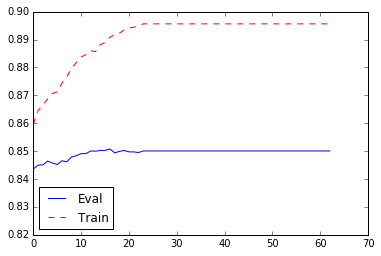

In [1478]:
plt.plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
        np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.82,0.9)
plt.show()

+  Cross Validation

In [1479]:
res = xgb.cv(param, dtrain_total, num_boost_round=10, nfold=5, metrics={'auc'}, seed=9999,\
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),\
                       xgb.callback.early_stop(3)])

[0]	train-auc:0.842692	test-auc:0.826799
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 3 rounds.
[1]	train-auc:0.844584	test-auc:0.828081
[2]	train-auc:0.849348	test-auc:0.829962
[3]	train-auc:0.8533	test-auc:0.831619
[4]	train-auc:0.856323	test-auc:0.834337
[5]	train-auc:0.859551	test-auc:0.835003
[6]	train-auc:0.861824	test-auc:0.835337
[7]	train-auc:0.86735	test-auc:0.839599
[8]	train-auc:0.868933	test-auc:0.840904
[9]	train-auc:0.872053	test-auc:0.842506


In [1480]:
dtest = xgb.DMatrix(test_x, label=test_y['blighted'])

In [1481]:
preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [1482]:
round(roc_auc_score(test_y, preds_proba), 5)

0.85331000000000001

### Average model

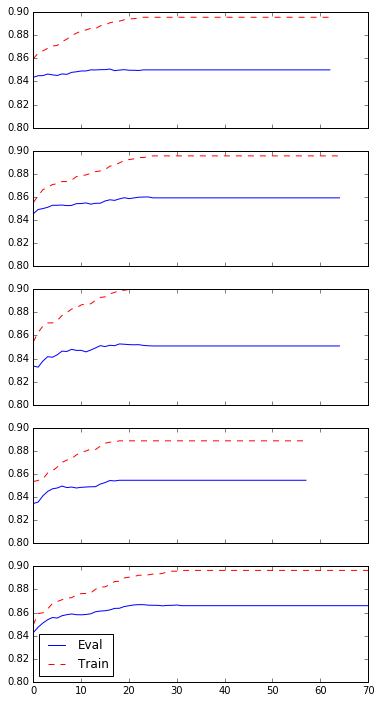

In [1488]:
bsts = []
fig, axes = plt.subplots(len(train_list), sharex=True, sharey=True, figsize=(6,12))
for train_data,i in zip(train_list,range(len(axes))):
    x_train, y_train = train_data
    x, x_eval, y, y_eval = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
    bst, evals_result = train_model(x, x_eval, y, y_eval, param)
    
    axes[i].plot(np.arange(len(evals_result['eval']['auc'])), evals_result['eval']['auc'], 'b-',\
            np.arange(len(evals_result['train']['auc'])), evals_result['train']['auc'], 'r--')
    bsts.append(bst)

plt.legend(['Eval','Train'], loc='best')
plt.ylim(0.8,0.9)
plt.show()

In [1484]:
#preds_proba = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
y_preds = np.mean(np.array([bst.predict(dtest, ntree_limit=bst.best_ntree_limit) for bst in bsts]), axis=0)

In [1485]:
round(roc_auc_score(test_y, y_preds), 5)

0.86246999999999996

An AUC score of **0.8625** was achieved by reducing variance.

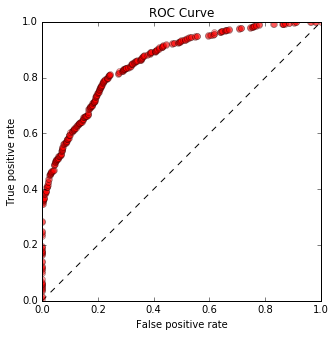

In [1489]:
fpr, tpr, thresholds = roc_curve(test_y, y_preds, pos_label=1)
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, 'ro',label='RF', alpha=0.4)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('../data/ROC_Curve_combined.png')
plt.show()